In [1]:
snp='rs72685323'
fold=6
snp_chrom="chr14"
snp_pos=51359100
ref='C'
alt='G'

In [2]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [3]:
from keras.models import load_model

Using TensorFlow backend.


In [4]:
import pysam
# SNP is at position 101 in the 200 bp MPRA construct 
def get_inputs(chrom,snp_pos,flank=100,ref="/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa"):
    ref=pysam.FastaFile(ref)
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}
    snp_pos=snp_pos-1 #convert to 0-indexing
    left_flank=ref.fetch(chrom,snp_pos-flank,snp_pos)
    print(left_flank[-10::])
    right_flank=ref.fetch(chrom,snp_pos+1,snp_pos+flank)
    print(right_flank[0:10])
    encoded=dict() 
    seqs=dict()
    for base in ['A','C','G','T']: 
        curseq=left_flank+base+right_flank
        seqs[base]=curseq
        encoded[base]=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in curseq]),0),0)
    return encoded,seqs

In [5]:
from abstention.calibration import PlattScaling, IsotonicRegression
from scipy.special import logit 

In [6]:
##load the model 
import pickle
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
from kerasAC.custom_losses import get_ambig_binary_crossentropy
import numpy as np 
custom_objects={"sensitivity":tpr,
                "specificity":tnr,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1,
                "ambig_binary_crossentropy":get_ambig_binary_crossentropy()}

model=load_model("v4/gecco.classification.SummitWithin200bpCenter."+str(fold),custom_objects=custom_objects)
predictions=pickle.load(open("/srv/scratch/annashch/deeplearning/gecco/crossvalid/v4/predictions."+str(fold),'rb'))
test_set_prediction_logits=predictions[-2]
test_set_labels=predictions[1]
#don't calibrate on nan inputs
try:
    test_set_labels=test_set_labels.values
except:
    pass
  
calibration_functions=dict() 
for i in range(5):
    nonambiguous_indices=np.argwhere(~np.isnan(test_set_labels[:,i]))
    classification_calibration_func = PlattScaling()(
    valid_preacts=test_set_prediction_logits[nonambiguous_indices,i],
    valid_labels=test_set_labels[nonambiguous_indices,i])
    calibration_functions[i]=classification_calibration_func

InternalError: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 12644188160

In [ ]:
#get deepLIFT function
from dragonn.tutorial_utils import * 
from dragonn.utils import one_hot_encode
from concise.utils.plot import seqlogo, seqlogo_fig


In [ ]:
#Now, pad to 1000 bp by using a 500 bp flank 
X,seqs=get_inputs(snp_chrom,snp_pos,flank=500)
X['C'].shape

In [17]:
tasks=["Healthy",'Tumor',"SW480","HCT116","COLO205"]
bases= ['A','C','G','T']

In [18]:

## pretty print
print('\t'+'\t'.join(tasks))
# get the model predictions 
for base in ['A','C','G','T']: 
    cur_prediction=model.predict(X[base])
    print("uncalibrated:"+base+'\t'+'\t'.join([str(i) for i in cur_prediction]))
    calibrated_predictions=[] 
for base in ['A','C','G','T']: 
    cur_prediction=model.predict(X[base])
    calibrated_predictions=[]     
    for i in range(len(tasks)): 
        calibrated_predictions.append(calibration_functions[i](logit(cur_prediction)[0,i])[0])
    print("calibrated:"+base+'\t'+'\t'.join([str(round(i,3)) for i in calibrated_predictions]))

	Healthy	Tumor	SW480	HCT116	COLO205
uncalibrated:A	[0.08046854 0.33181372 0.25830117 0.04975243 0.18850769]
uncalibrated:C	[0.06819648 0.3254178  0.14780147 0.0526294  0.14713031]
uncalibrated:G	[0.09967601 0.40966097 0.31052032 0.09056915 0.22151415]
uncalibrated:T	[0.07246087 0.30410516 0.14836638 0.04332181 0.15204732]
calibrated:A	0.022	0.081	0.068	0.012	0.076
calibrated:C	0.018	0.079	0.032	0.013	0.05
calibrated:G	0.03	0.115	0.089	0.026	0.101
calibrated:T	0.019	0.071	0.032	0.01	0.053


## ISM Mutation Map

In [19]:
import numpy as np 
def in_silico_mutagenesis(model, X):
    """                                                                                                                                                                                                                               
    Returns (num_task, num_samples, 1, num_bases, sequence_length) ISM score array.                                                                                                                                                   
    """
    mutagenesis_scores = np.empty(
        X.shape + (model.output_shape[1],), dtype=np.float32)
    wild_type_predictions = model.predict(X)
    wild_type_predictions = wild_type_predictions[
        :, np.newaxis, np.newaxis, np.newaxis]
    for sequence_index, (sequence, wild_type_prediction) in enumerate(
            zip(X, wild_type_predictions)):
        mutated_sequences = np.repeat(
            sequence[np.newaxis], np.prod(sequence.shape), axis=0)
        # remove wild-type                                                                                                                                                                                                            
        arange = np.arange(len(mutated_sequences))
        horizontal_cycle = np.tile(
            np.arange(sequence.shape[-1]), sequence.shape[-2])
        mutated_sequences[arange, :, :, horizontal_cycle] = 0
        # add mutant                                                                                                                                                                                                                  
        vertical_repeat = np.repeat(
            np.arange(sequence.shape[-2]), sequence.shape[-1])
        mutated_sequences[arange, :, vertical_repeat, horizontal_cycle] = 1
        # make mutant predictions                                                                                                                                                                                                     
        mutated_predictions = model.predict(mutated_sequences)
        mutated_predictions = mutated_predictions.reshape(
            sequence.shape + (model.output_shape[1],))
        mutagenesis_scores[
            sequence_index] = wild_type_prediction - mutated_predictions
    mutagenesis_scores=np.rollaxis(mutagenesis_scores,-1)
    mutagenesis_scores=np.squeeze(mutagenesis_scores)
    #column-normalize the mutagenesis scores                                                                                                                                                                                          
    col_sum = mutagenesis_scores.sum(axis=0)
    normalized_mutagenesis_scores = (mutagenesis_scores)/col_sum
    return normalized_mutagenesis_scores


In [25]:
def plot_ism(ism_mat,title,vmin=None,vmax=None):
    # create discrete colormap of ISM scores                                                                                                                                                                                          
    extent = [0, ism_mat.shape[0], 0, 100*ism_mat.shape[1]]
    plt.figure(figsize=(50,3))
    if vmin==None:
        vmin=np.amin(ism_mat)
    if vmax==None:
        vmax=np.amax(ism_mat)
    plt.imshow(ism_mat.T,extent=extent,vmin=vmin, vmax=vmax)
    plt.xlabel("Sequence base")
    plt.ylabel("ISM Score")
    plt.title(title)
    plt.yticks(np.arange(50,100*ism_mat.shape[1],100),("A","C","G","T"))
    plt.set_cmap('RdBu')
    plt.colorbar()
    plt.show()


In [26]:
ism_mat=in_silico_mutagenesis(model,X['C'])

In [27]:
ism_mat.shape

(5, 1000, 4)

<Figure size 3600x216 with 0 Axes>

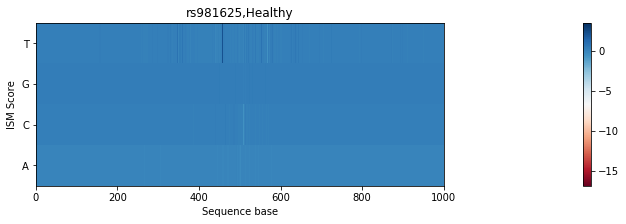

In [29]:
matplotlib.rcParams['figure.figsize'] = [width, height]
plot_ism(ism_mat[0].squeeze(),"rs981625,Healthy")

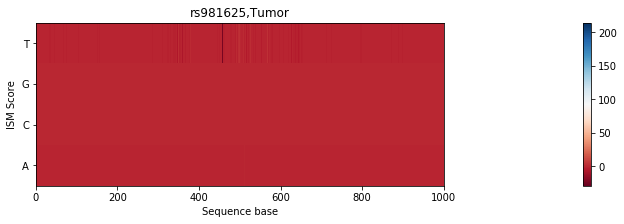

In [30]:
plot_ism(ism_mat[1].squeeze(),"rs981625,Tumor")

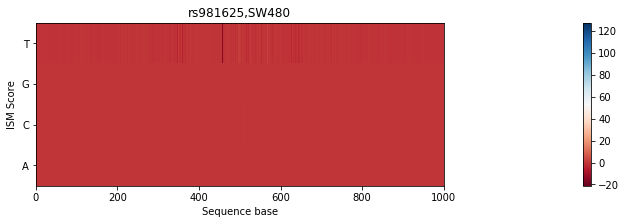

In [31]:
plot_ism(ism_mat[2].squeeze(),"rs981625,SW480")

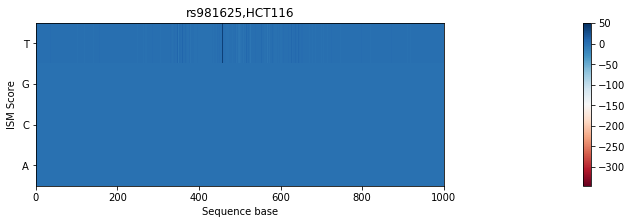

In [32]:
plot_ism(ism_mat[3].squeeze(),"rs981625,HCT116")

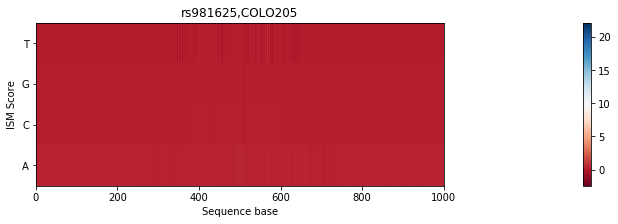

In [33]:
plot_ism(ism_mat[4].squeeze(),"rs981625,COLO205")

## Grad x input

In [12]:
from keras import backend as K 
def get_grad_by_input(model,inputs):
    grad_tensor=K.gradients(model.layers[-2].output,model.layers[0].input)
    grad_func = K.function([model.layers[0].input,K.learning_phase()], grad_tensor)
    gradient = grad_func([inputs, False])[0]
    normed_gradient = gradient-np.mean(gradient, axis=3)[:,:,:,None]
    normed_grad_times_inp = normed_gradient*inputs
    return normed_grad_times_inp.squeeze()

In [13]:
gradxinput_C=get_grad_by_input(model,X['C'])

In [14]:
gradxinput_G=get_grad_by_input(model,X['G'])

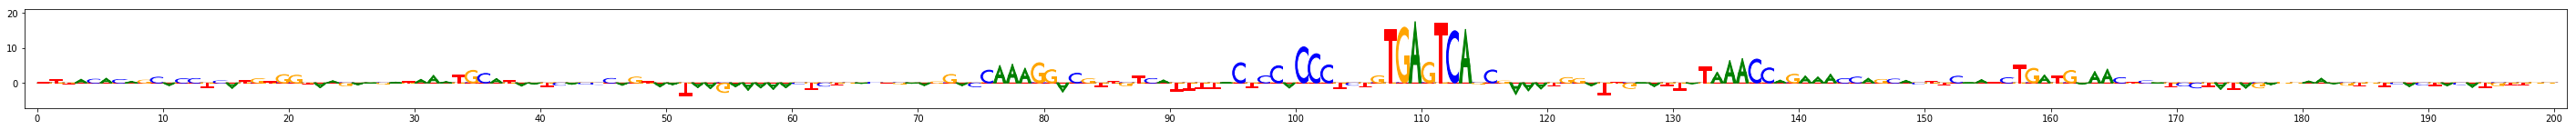

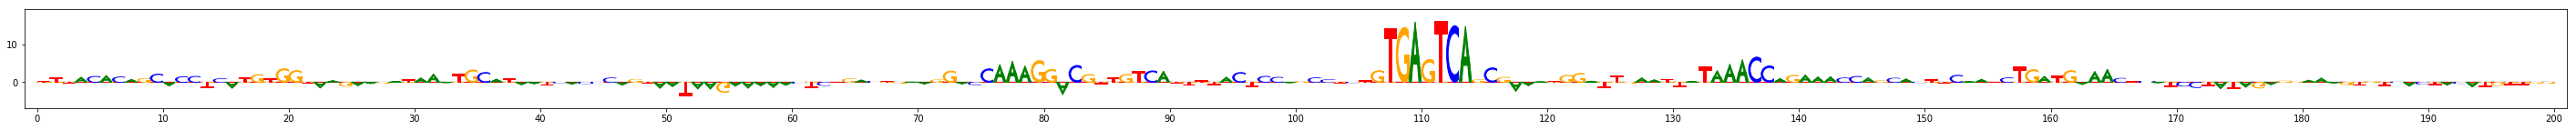

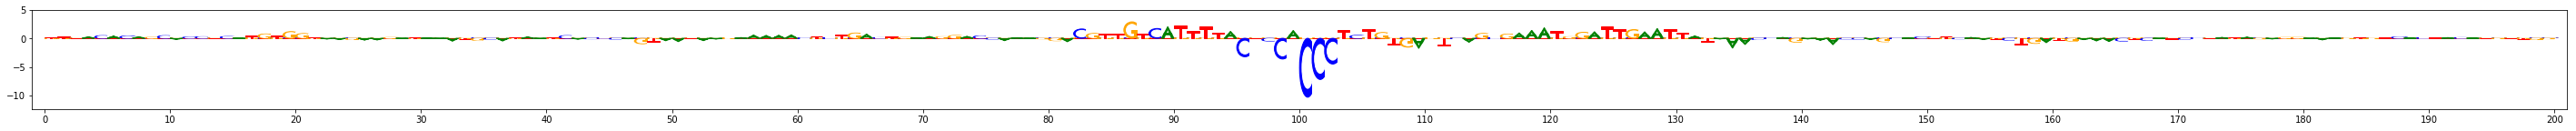

In [15]:
from deeplift.visualization import viz_sequence
viz_sequence.plot_weights(gradxinput_C[400:600],figsize=(50, 2), subticks_frequency=10)
viz_sequence.plot_weights(gradxinput_G[400:600],figsize=(50, 2), subticks_frequency=10)
viz_sequence.plot_weights(gradxinput_G[400:600]-gradxinput_C[400:600],figsize=(50, 2), subticks_frequency=10)

## DeeLIFT shuffled ref 

In [19]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores=dict() 
for t_index in range(5):
    dl_scores[tasks[t_index]]=dict() 
    for base in ['A','C','G','T']:
        dl_scores[tasks[t_index]][base]=deeplift("v4/gecco.classification.SummitWithin200bpCenter."+str(fold),
                                         X[base],
                                         task_idx=t_index,
                                         num_refs_per_seq=1,
                                         batch_size=1,
                                         reference='shuffled_ref')

got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!
got score func!


In [20]:
def plot_seq_importance(grads, x, xlim=None, ylim=None, layer_idx=-2, figsize=(25, 3),title="",snp_pos=101):
    """Plot  sequence importance score                                                                                                                   
                                                                                                                                                         
    Args:                                                                                                                                                
      grads: either deeplift or gradientxinput score matrix                                                                                              
      x: one-hot encoded DNA sequence                                                                                                                    
      xlim: restrict the plotted xrange                                                                                                                  
      figsize: matplotlib figure size                                                                                                                    
    """
    grads=grads.squeeze()
    x=x.squeeze()

    seq_len = x.shape[0]
    vals_to_plot=grads*x
    if xlim is None:
        xlim = (0, seq_len)
    if ylim is None:
        ylim= (np.amin(vals_to_plot),np.amax(vals_to_plot))
    seqlogo_fig(vals_to_plot, figsize=figsize)
    plt.xticks(list(range(xlim[0], xlim[1], 5)))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.axvline(x=snp_pos, color='k', linestyle='--')

In [21]:
def plot_dl(dl_scores,X,task,ref_allele,alt_allele,start_index=400,end_index=600,ylim_min=-0.4,ylim_max=0.4):
    tmp1=dl_scores[task][ref_allele][0].squeeze()[start_index:end_index]
    tmp2=X[ref_allele].squeeze()[start_index:end_index]
    print("ref:"+str(ref))
    print(plot_seq_importance(tmp1,tmp2,ylim=(ylim_min,ylim_max)))
    tmp3=dl_scores[task][alt_allele][0].squeeze()[start_index:end_index]
    tmp4=X[alt_allele].squeeze()[start_index:end_index]
    print("alt:"+str(alt))
    print(plot_seq_importance(tmp3,tmp4,ylim=(ylim_min,ylim_max)))
    print("alt - ref")
    print(plot_seq_importance(tmp3-tmp1,tmp4,ylim=(ylim_min,ylim_max)))
    return

In [22]:
ref="C"
alt="G"

ref:C
None
alt:G
None
alt - ref
None


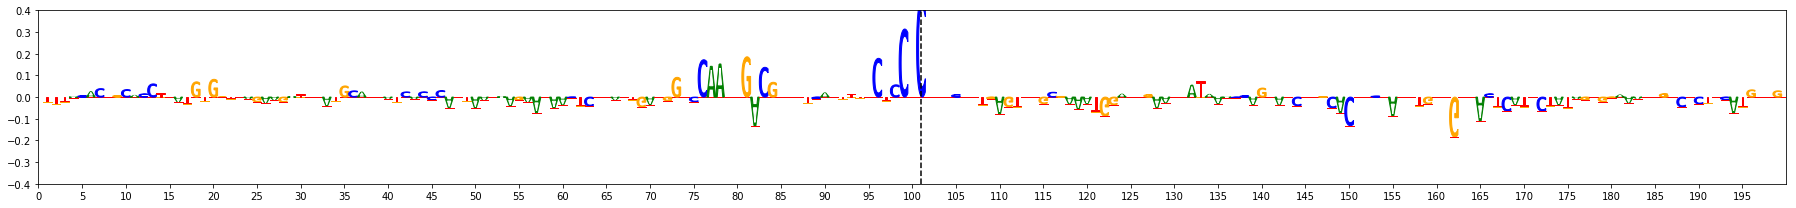

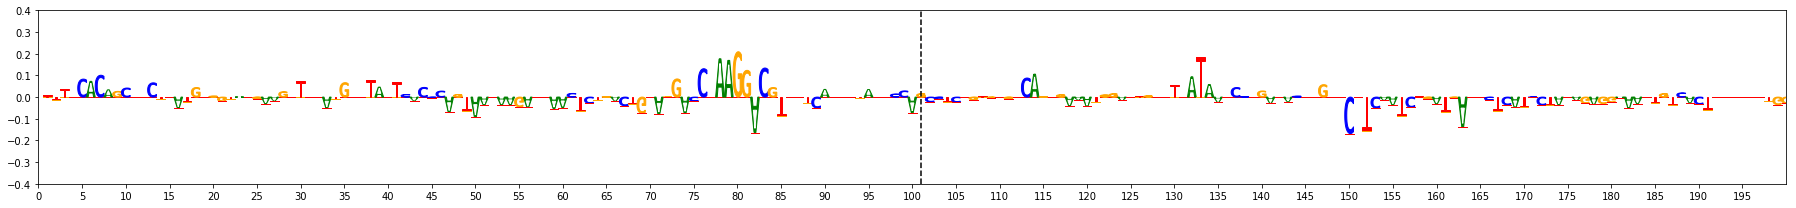

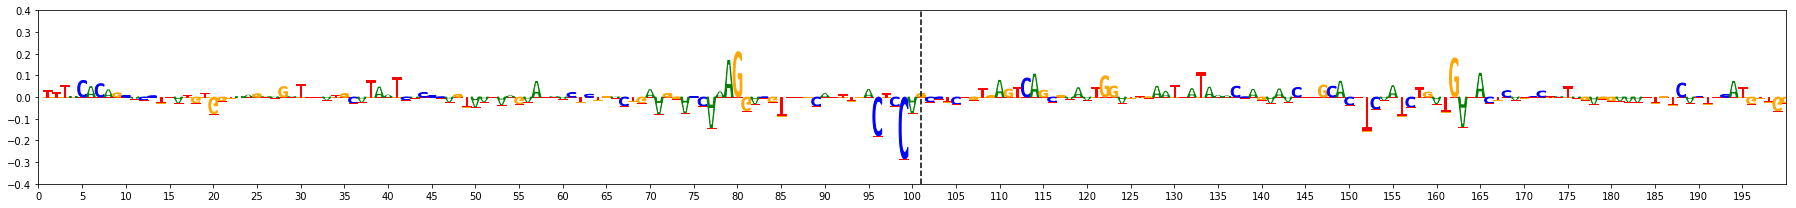

In [23]:
plot_dl(dl_scores,X,"Healthy",ref,alt)  

ref:C
None
alt:G
None
alt - ref
None


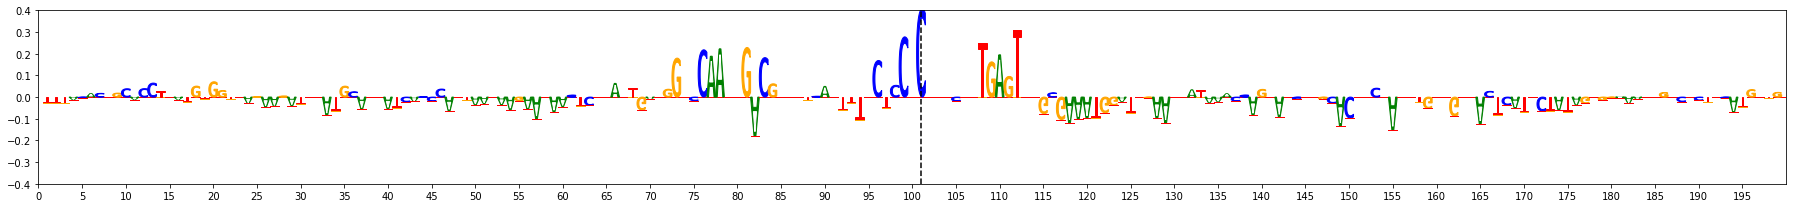

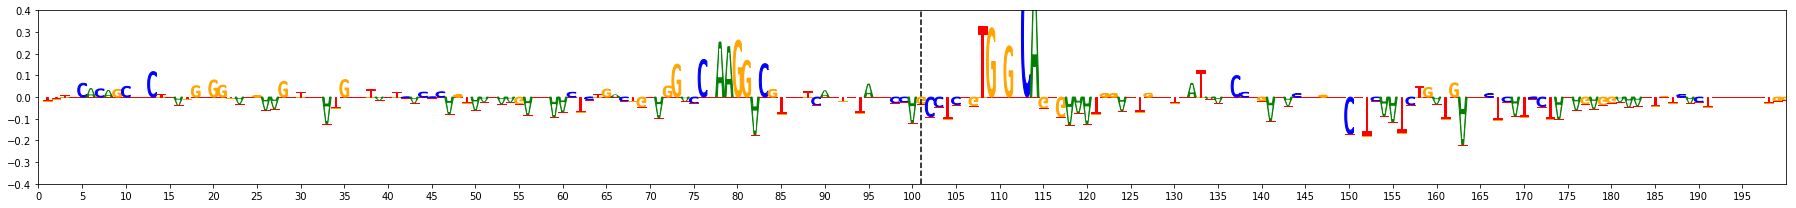

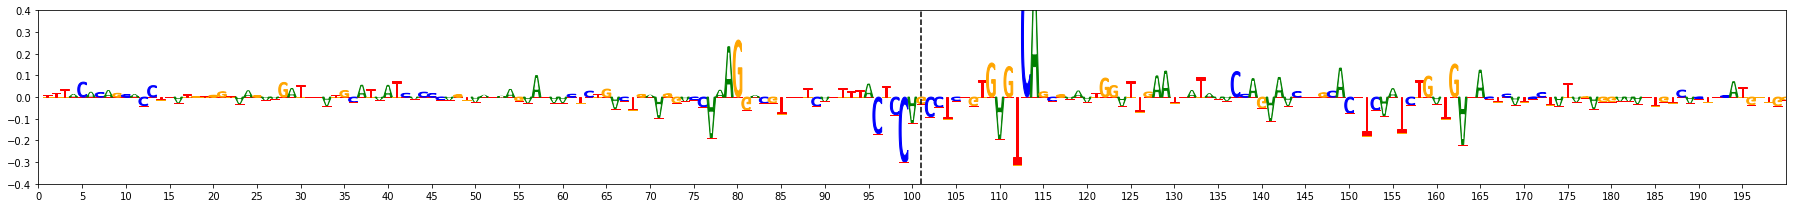

In [24]:
plot_dl(dl_scores,X,"Tumor",ref,alt)  

ref:C
None
alt:G
None
alt - ref
None


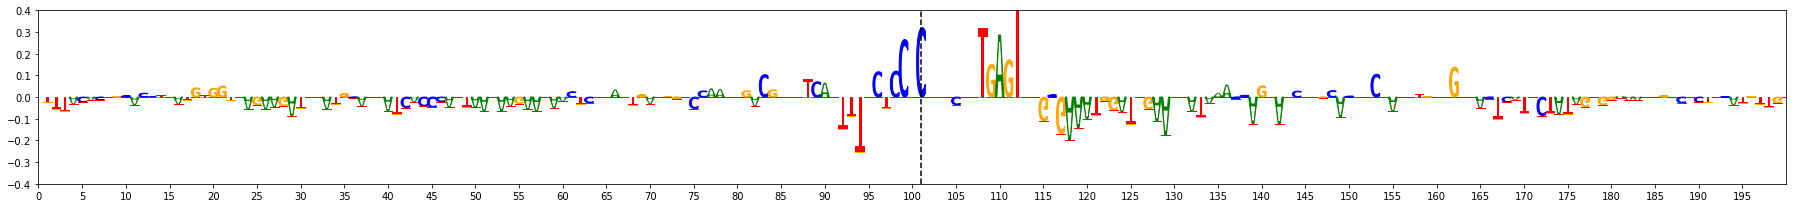

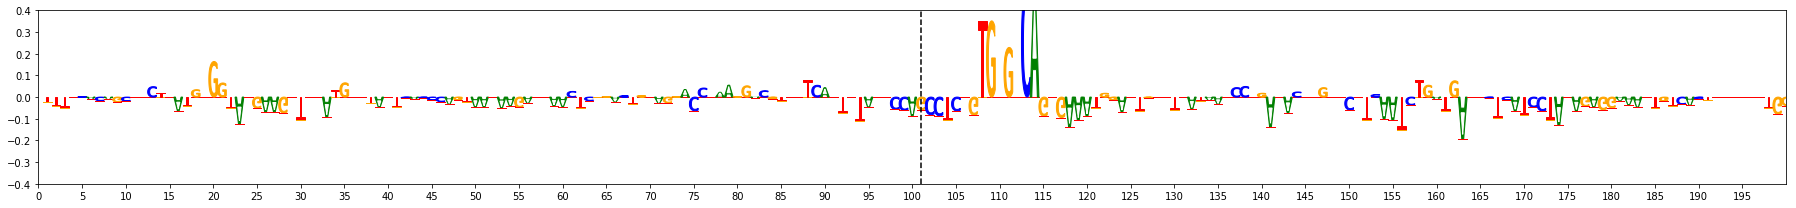

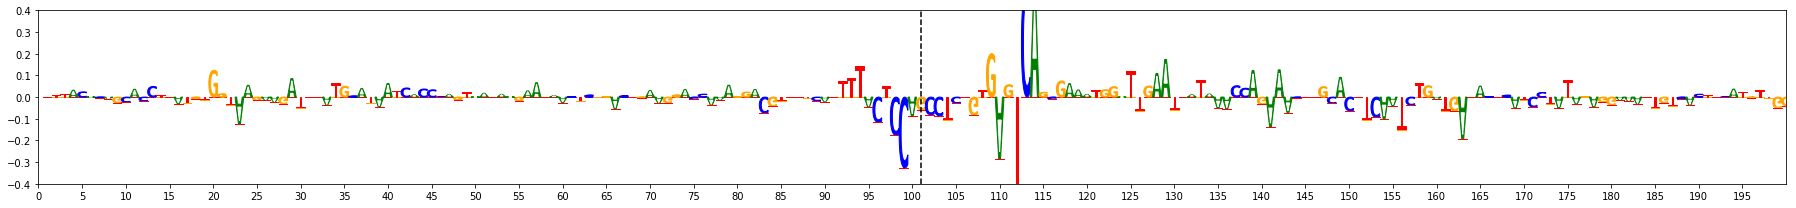

In [25]:
plot_dl(dl_scores,X,"SW480",ref,alt)  

ref:C
None
alt:G
None
alt - ref
None


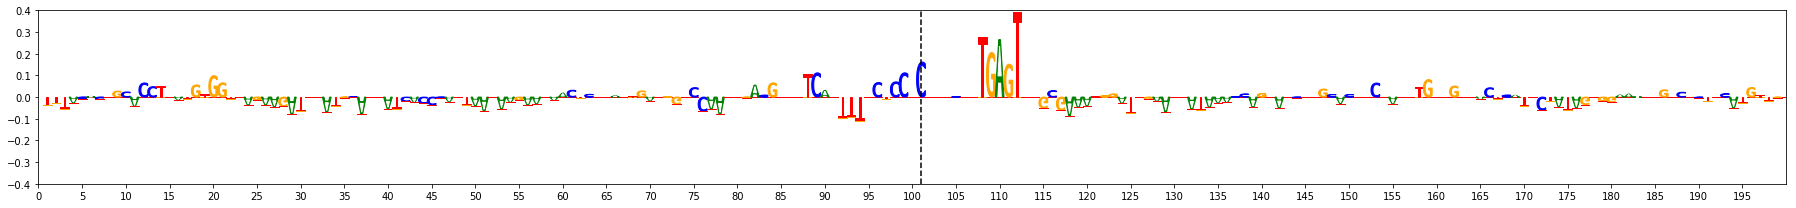

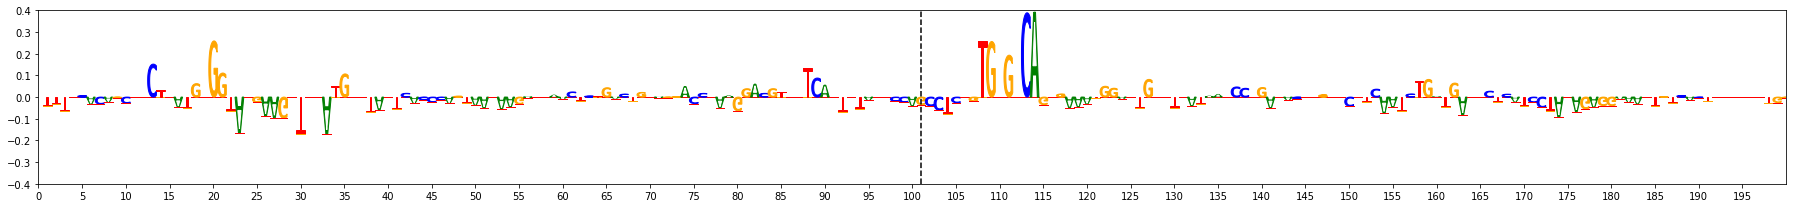

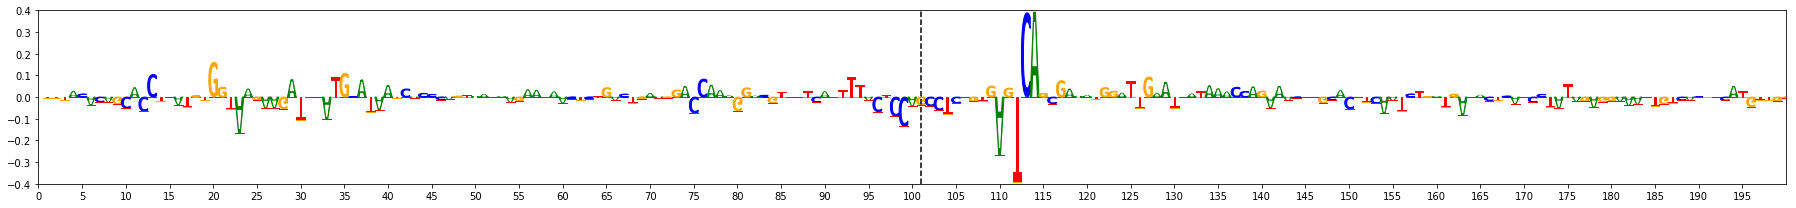

In [26]:
plot_dl(dl_scores,X,"HCT116",ref,alt)  

ref:C
None
alt:G
None
alt - ref
None


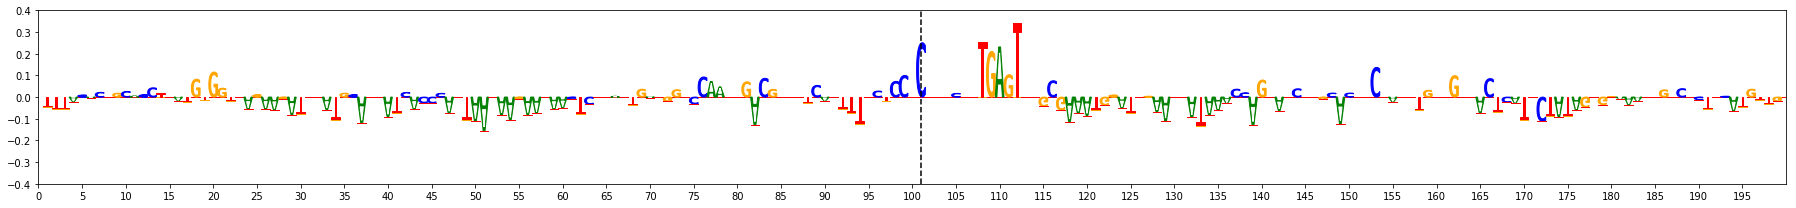

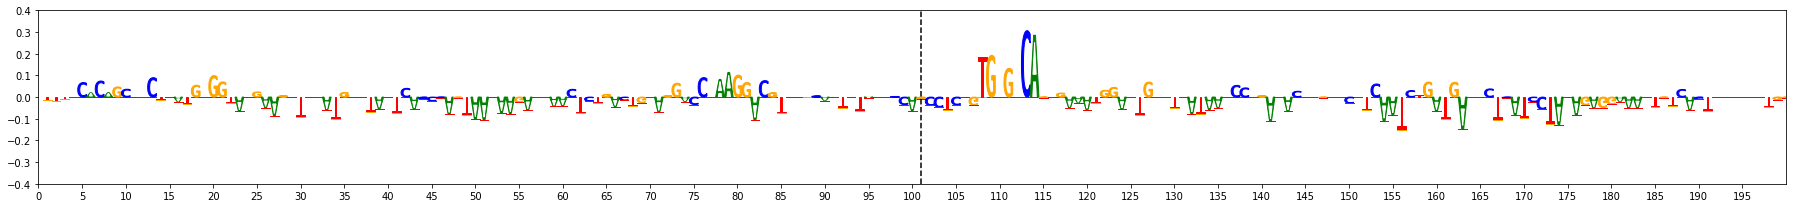

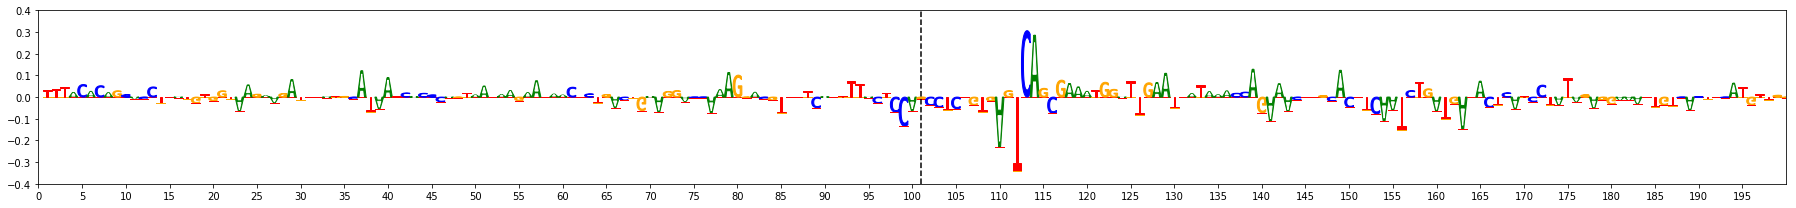

In [27]:
plot_dl(dl_scores,X,"COLO205",ref,alt)  